In [1]:
from vesicle_picker import helpers, preprocess, generate_masks, postprocess, external_import, external_export, funcs_mrcio
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [1]:
# P179

In [2]:
# Import the example mrc
image_fullres, header = helpers.import_mrc("example_micrographs/P199_example_micrographs/FoilHole_21958024_Data_21960128_4_20240222_223016_EER_patch_aligned_doseweighted.mrc")

In [23]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=1, 
                                                           lowpass_mode = "bilateral",
                                                           d = 35,
                                                           sigmaColor=91,
                                                           sigmaSpace=91)

(-0.5, 4095.5, 4095.5, -0.5)

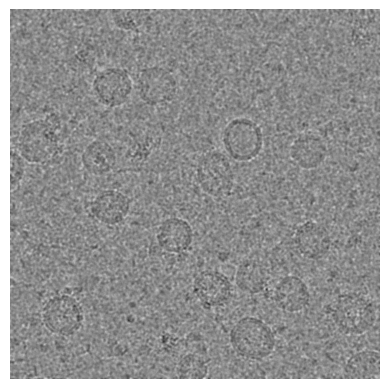

In [24]:
# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

In [5]:
# Initialize the model
model = generate_masks.initialize_model(model_weights_path = "../sam_vit_h_4b8939.pth", device='cuda:0')

In [6]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(preprocessed_micrograph, model, 
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.15,
    min_mask_region_area=100,
    psize=1.03,
    downsample=1)

In [7]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(masks, 
                              [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
                              preprocessed_micrograph)

In [8]:
# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes of the postprocessed values, for downstream visualizations.
# See `vesicle_diagnostics.ipynb` for more details on how to do this for a collection of micrographs.
unfiltered_dataset, filtered_dataset = postprocess.extract_statistics(postprocessed_masks, "filters.ini")

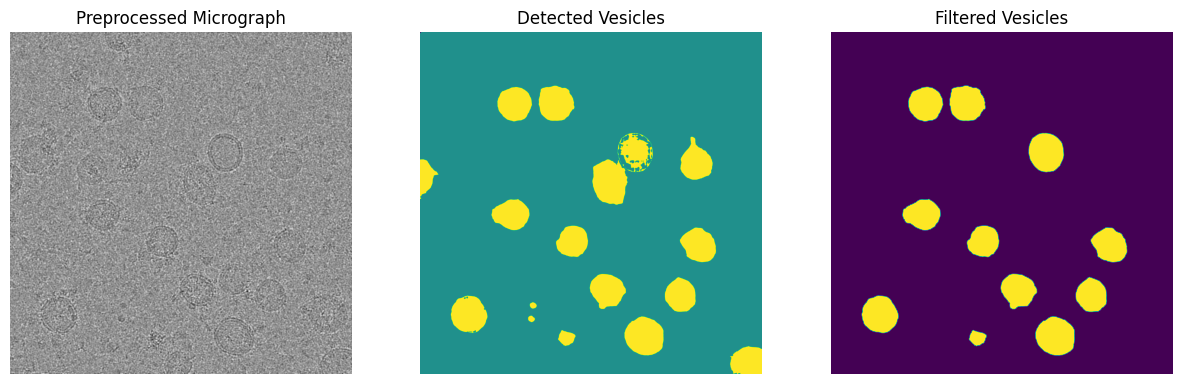

In [9]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

In [10]:
import copy

# Once you have a set of filters you like, generate the picks
pick_indices = postprocess.generate_picks(filtered_masks, 1.5, 4, 100, mode='edge')

# # Dilate the masks
dilated_masks = postprocess.dilate_masks(copy.deepcopy(filtered_masks), 60, 1.03, 1)
dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 1, 128, mode='edge')

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

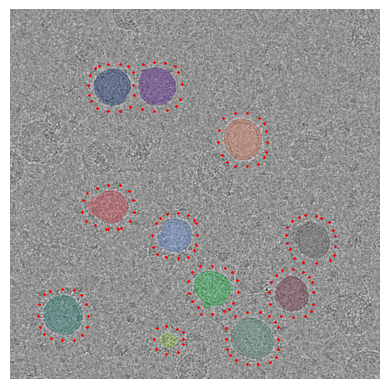

In [12]:
# # Plot the preprocessed image...
# plt.imshow(preprocessed_micrograph, cmap="Greys_r")
# plt.show()
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=1, 
                                                           lowpass_mode = "bilateral",
                                                           d = 17,
                                                           sigmaColor=201,
                                                           sigmaSpace=201)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
show_anns(filtered_masks)
#ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
ax1.scatter(dilated_pick_indices[1], dilated_pick_indices[0], marker='x', color='red', s=1)
plt.axis('off')
plt.savefig("example_micrographs/P199_example_micrographs/annotated_1.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()